# Check accuarcy of our model

In [1]:
import sys
sys.path.append("..")
import argparse
import logging
import matplotlib.pyplot as plt
import math
import os
import random
import time

import numpy as np
import torch
from torch.cuda import amp
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm as tqdm
# from tqdm import tqdm_notebook as tqdm
import torchvision.models
import torch.nn as nn

from torchvision import transforms
import torch.utils.data as data

from augmentation import RandAugment

from PIL import Image
import pandas as pd

from data import DATASET_GETTERS
from models import WideResNet, ModelEMA, RestNet18
from utils import (AverageMeter, accuracy, create_loss_fn,
                   save_checkpoint, reduce_tensor, model_load_state_dict)
from PIL import Image

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
seed = 5
num_classes = 8
total_steps = 10000
eval_step = 100
batch_size = 32
teacher_lr = 1e-3
student_lr = 1e-3
label_smoothing = 0.1
lambda_u = 8 
warmup_steps = 0
uda_steps = 10000
student_wait_steps = 0
resize = 224
workers = 16
best_top1 = 0
best_top2 = 0
mu = 1
ema = 0.995
batch_size = 32
gpu = 0
device = torch.device('cuda', gpu)
momentum = 0.9
nesterov = True
threshold = 0.6


In [3]:
ckpt_name = 'F2E.pth.tar'

In [4]:
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5863, 0.4595, 0.4030), std=(0.2715, 0.2424, 0.2366))
])

orginal_dataset_dir = '/home/data/lzy/AffectNet/Manually_Annotated/Manually_Annotated_Images/'
path_meta_val = '/home/data/lzy/AffectNet/Manually_Annotated_file_lists/validation.csv'
DF2 = pd.read_csv(path_meta_val)
DFselect2 = DF2.loc[DF2['expression'] <7]


class AfData(data.Dataset):
    def __init__(self,data,directory,transform):
        self.data = data
        self.directory = directory
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        path = os.path.join(self.directory, self.data.iloc[idx]['subDirectory_filePath'])
        x,y,w,h = self.data.iloc[idx]['face_x'],self.data.iloc[idx]['face_y'],self.data.iloc[idx]['face_width'],self.data.iloc[idx]['face_height']
        target = self.data.iloc[idx]['expression']
        image = Image.open(path).convert('RGB')
        #image = cv2.imread(path, cv2.COLOR_BGR2RGB)
        cropped = image.crop((x, y, x+w, y+h))
        img = self.transform(cropped)
        return img, target
    

In [5]:
def create_loss_fn():
    if label_smoothing > 0:
        criterion = SmoothCrossEntropy(alpha=label_smoothing)
    else:
        criterion = nn.CrossEntropyLoss()
    return criterion.to(device)

class SmoothCrossEntropy(nn.Module):
    def __init__(self, alpha=0.1):
        super(SmoothCrossEntropy, self).__init__()
        self.alpha = alpha

    def forward(self, logits, labels):
        num_classes = logits.shape[-1]
        alpha_div_k = self.alpha / num_classes
        target_probs = F.one_hot(labels, num_classes=num_classes).float() * \
            (1. - self.alpha) + alpha_div_k
        loss = -(target_probs * torch.log_softmax(logits, dim=-1)).sum(dim=-1)
        return loss.mean()

In [6]:
device = torch.device('cuda', gpu)
model = torchvision.models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 7)
model.cuda()
model = model.to(device)

loc = f'cuda:{gpu}'

state_dict = torch.load(ckpt_name, map_location=loc)
model.load_state_dict(state_dict['student_state_dict'])

test_dataset = AfData(data=DFselect2, directory=orginal_dataset_dir, transform=transform_val)
train_dataset = AfData(data=DFselect2, directory=orginal_dataset_dir, transform=transform_val)

In [7]:
batch_time = AverageMeter()
data_time = AverageMeter()
losses = AverageMeter()
top1 = AverageMeter()
top2 = AverageMeter()
model.eval()

train_sampler = RandomSampler

test_loader = DataLoader(test_dataset,
                         sampler=SequentialSampler(test_dataset),
                         batch_size=batch_size,
                         num_workers=workers,
                         pin_memory=True
                         )

train_loader = DataLoader(train_dataset,
        sampler=train_sampler(train_dataset),
        batch_size=batch_size * mu,
        num_workers=workers,
        pin_memory=True)

test_iter = tqdm(test_loader, disable=False)

criterion = create_loss_fn()

with torch.no_grad():
    end = time.time()
    for step, (images, targets) in enumerate(test_iter):
        data_time.update(time.time() - end)
        batch_size = targets.shape[0]
        images = images.to(device)
        targets = targets.to(device)
        with amp.autocast(enabled=True):
            outputs = model(images)
            loss = criterion(outputs, targets)

        acc1, acc2 = accuracy(outputs, targets, (1, 2))
        losses.update(loss.item(), batch_size)
        top1.update(acc1[0], batch_size)
        top2.update(acc2[0], batch_size)
        batch_time.update(time.time() - end)
        end = time.time()
        test_iter.set_description(
            f"Test Iter: {step + 1:3}/{len(test_loader):3}.  "
            f"Loss: {losses.avg:.4f}. "
            f"top1: {top1.avg:.2f}. top2: {top2.avg:.2f}. ")

    test_iter.close()

  0%|          | 0/110 [00:00<?, ?it/s]

# Test a single image

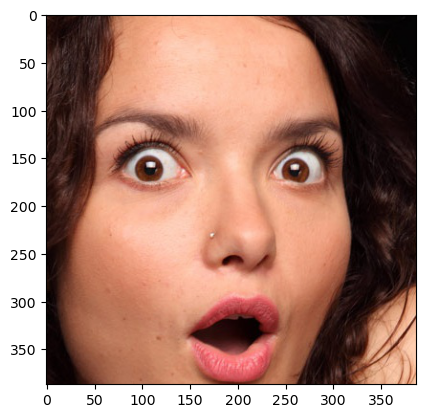

In [8]:
path="image.jpg"
image = Image.open(path).convert('RGB')
plt.imshow(image)
plt.show()

In [9]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5863, 0.4595, 0.4030), std=(0.2715, 0.2424, 0.2366))
])

img = transform(image)
img = img.unsqueeze(0)
img = img.to(device)
img.shape

torch.Size([1, 3, 224, 224])

In [10]:
predict = model(img)
predict = torch.softmax(predict.detach(),dim=-1)
predict

tensor([[0.0179, 0.0360, 0.0040, 0.7022, 0.1931, 0.0178, 0.0289]],
       device='cuda:0')

In [11]:
torch.argmax(predict)

tensor(3, device='cuda:0')

In [12]:
aff_expression=["Neutral","Happy","Sad","Surprise","Fear","Disgust","Anger","Contempt"]
def display(image,predict):
    print("Predict expression:",aff_expression[torch.argmax(predict).item()])
    print("Predict confidence:",torch.max(predict).item())
    plt.imshow(image)
    plt.show()

Predict expression: Surprise
Predict confidence: 0.7022401094436646


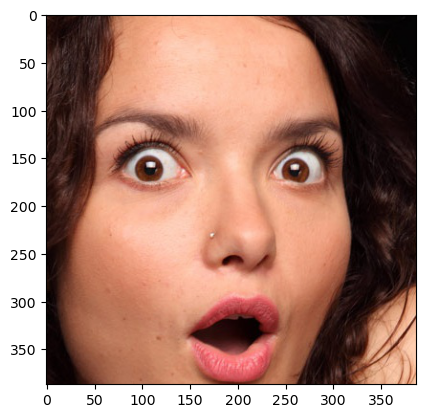

In [13]:
display(image,predict)